## COVID-19 NOTEBOOK

Análise aos dados de Covid-19 de Portugal com base nos relatórios publicados pela [DGS](https://covid19.min-saude.pt/relatorio-de-situacao/)

### Secções
1. [Evolução dos Casos](#evolucao_casos)
2. [Taxas de crescimento](#taxas_crescimento)
3. [Número de testes](#numero_testes)
4. [Comparação com outros países](#comparacao_outros_paises)


In [24]:
# fonte: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')



In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline


In [90]:
dados_pt = pd.read_csv('Covid-19 - Portugal.csv')

# olhar para periodo acima deste numero de casos
n_casos_analise = 200

pt_casos = dados_pt.loc[dados_pt['ConfirmedCases'] >= n_casos_analise, :].copy()

pt_casos['ndia'] = np.arange(len(pt_casos['ConfirmedCases']))

pt_casos['NewCases'] = pt_casos['ConfirmedCases'].diff()
pt_casos['NewCasesPerc'] = (pt_casos['NewCases'] / pt_casos['ConfirmedCases'])*100
pt_casos['HospitalizedPerc'] = (pt_casos['Hospitalized'] / pt_casos['ConfirmedCases'])*100
pt_casos['UCIPerc'] = (pt_casos['UCI'] / pt_casos['ConfirmedCases'])*100
pt_casos['DeathsPerc'] = (pt_casos['Deaths'] / pt_casos['ConfirmedCases'])*100
pt_casos['RecoveredPerc'] = (pt_casos['Recovered'] / pt_casos['ConfirmedCases'])*100

pt_casos['LogGrowthCases'] = np.log(pt_casos['ConfirmedCases'])
pt_casos['LogGrowthHospitalized'] = np.log(pt_casos['Hospitalized'])
pt_casos['LogGrowthUCI'] = np.log(pt_casos['UCI'])
pt_casos['LogGrowthRecovered'] = np.log(pt_casos['Recovered'])

# warning divide by 0
pt_casos['LogGrowthDeaths'] = np.log(pt_casos.Deaths[pt_casos['Deaths'] > 0])

# Dates
pt_casos['Date'] = pd.to_datetime(pt_casos['Date'], format=r"%d/%m/%Y")


## Evolução dos casos <a name="evolucao_casos"></a>

Evolução dos casos de cada quantidade a partir dos 200 casos confirmados. 

### Casos confirmados

Comparação com taxas de crecimento de duplicação a cada 2, 3 e 4 dias.

### Casos Hospitalizados, UCI, Óbitos e Recuperados

Número de casos e qual é a sua percentagem dos casos confirmados

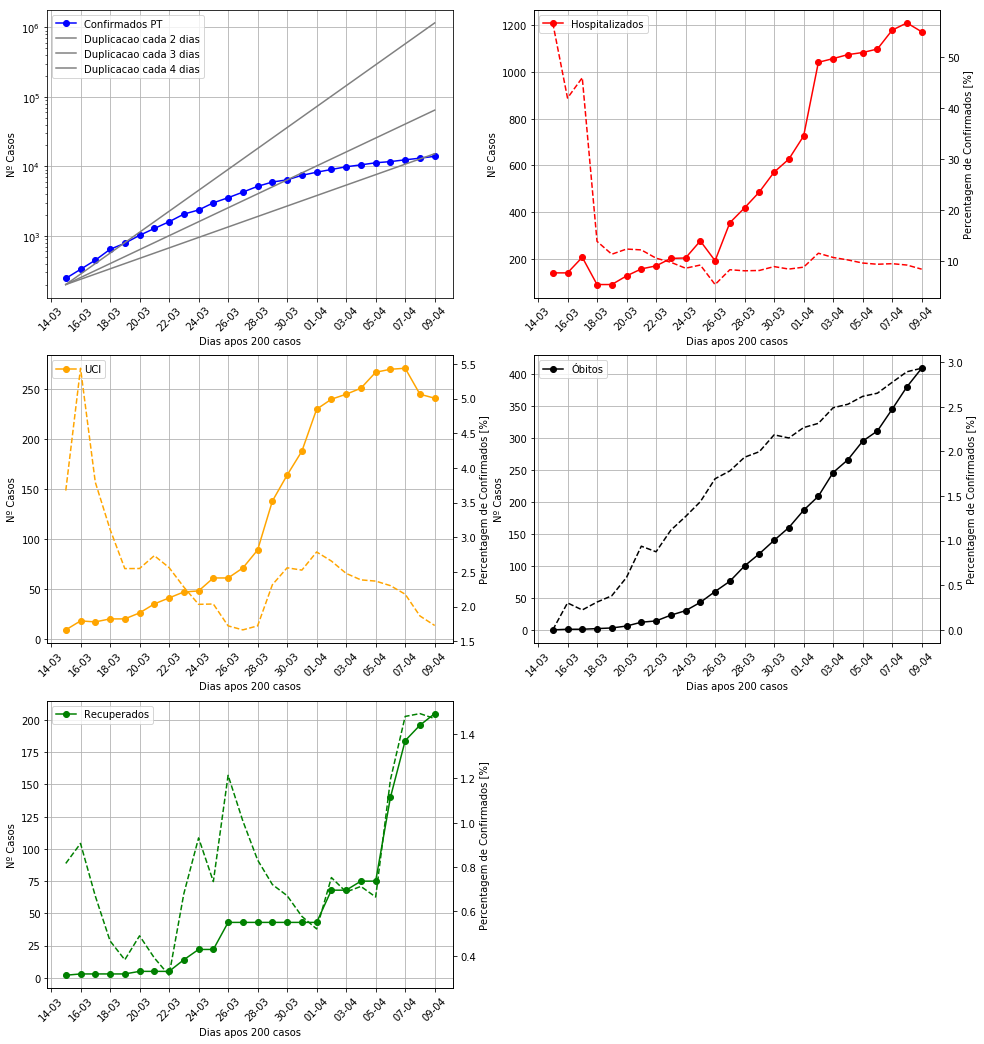

In [96]:
plt.figure(figsize=(16,18))
plt.subplot(3, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['ConfirmedCases'], '-o', color='blue', label='Confirmados PT')
plt.yscale('log')

# Referencia
n_dias_dup = 2
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 2 dias', color='grey')
n_dias_dup = 3
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 3 dias', color='grey')
n_dias_dup = 4
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 4 dias', color='grey')

plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Nº Casos')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.legend()

plt.subplot(3, 2, 2)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Hospitalized'], '-o', color='red', label='Hospitalizados')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['HospitalizedPerc'], '--', color='red', label='Hospitalizados percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.subplot(3, 2, 3)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['UCI'], '-o', color='orange', label='UCI')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['UCIPerc'], '--', color='orange', label='UCI percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.subplot(3, 2, 4)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Deaths'], '-o', color='black', label='Óbitos')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['DeathsPerc'], '--', color='black', label='Óbitos percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.subplot(3, 2, 5)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Recovered'], '-o', color='green', label='Recuperados')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['RecoveredPerc'], '--', color='green', label='Recuperados percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))


## Taxas de crescimento <a name="taxas_crescimento"></a>

Crescimento é dado pelo declive das amostras em escala logaritmica por unidade de tempo ($dia^{-1}$). [Ver mais](http://e-escola.tecnico.ulisboa.pt/topico.asp?id=233&ordem=2)

O crescimento foi calculado para uma janela de 4 dias, ou seja, cada ponto corresponde ao crescimento do dia e dos 3 anteriores. Desta forma eliminamos as variações rápidas entre cada dia e obtemos um recta mais suave. Podemos diminuir esta janela até 2 dias para observar o crescimento de dia para dia ou no limite até ao periodo todo para analisarmos o crescimento no seu global.

Dados:
* Casos confirmados
* Hospitalizados e internados em UCI
* Óbitos
* Recuperados


In [98]:
janela_temporal = 4 # dias (minimo 2 dias)

pt_casos['TaxaCrescimentoConfirmadasJanela'] = pt_casos['LogGrowthCases'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoHospitalizadosJanela'] = pt_casos['LogGrowthHospitalized'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoUCIJanela'] = pt_casos['LogGrowthUCI'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoMortosJanela'] = pt_casos['LogGrowthDeaths'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoRecuperadosJanela'] = pt_casos['LogGrowthRecovered'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)


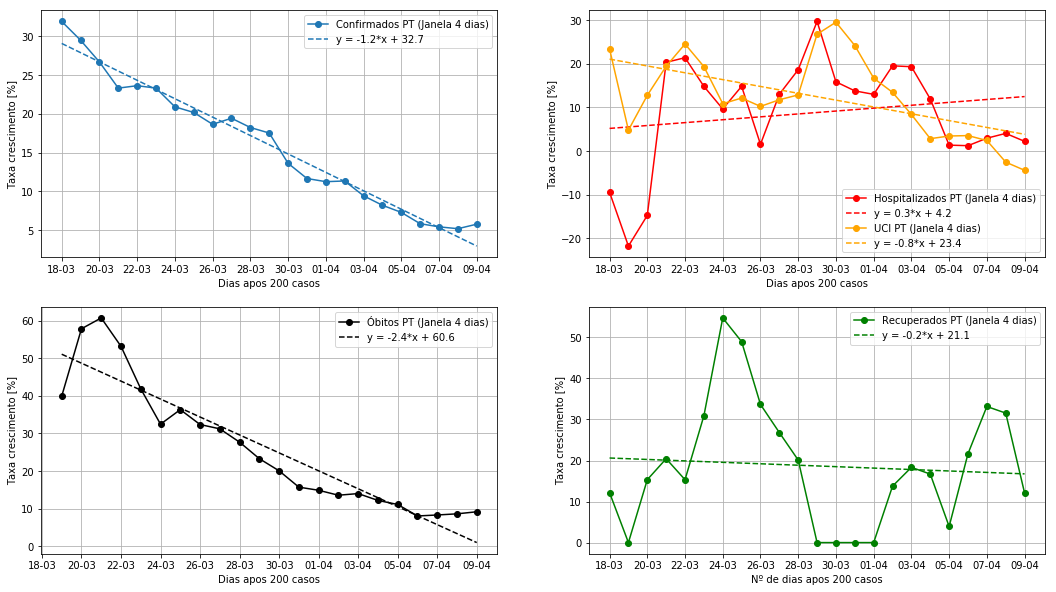

In [99]:
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoConfirmadasJanela']*100, '-o', label='Confirmados PT (Janela ' + str(janela_temporal) +' dias)')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoConfirmadasJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoConfirmadasJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoConfirmadasJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='C0', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
# Hospitalizados
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoHospitalizadosJanela']*100, '-o', label='Hospitalizados PT (Janela ' + str(janela_temporal) +' dias)', color='red')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoHospitalizadosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoHospitalizadosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoHospitalizadosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='red', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )
# UCI
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoUCIJanela']*100, '-o', label='UCI PT (Janela '+ str(janela_temporal)+' dias)', color='orange')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoUCIJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoUCIJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoUCIJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='orange', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoMortosJanela']*100, '-o', label='Óbitos PT (Janela ' + str(janela_temporal) +' dias)', color='black')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoMortosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoMortosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoMortosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='black', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoRecuperadosJanela']*100, '-o', label='Recuperados PT (Janela ' + str(janela_temporal) +' dias)', color='green')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoRecuperadosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoRecuperadosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoRecuperadosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='green', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Nº de dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()
plt.show()

## Numero de Testes <a name="numero_testes"></a>

Número de testes obtido pelo total de casos, que inclui o número de casos confirmados, casos não confirmados e que aguardam teste.

In [30]:
populacao_pt = 10280000
fraccao_populacao_100k = 100000 / populacao_pt
pt_casos.insert(1, 'NewTests', pt_casos['TotalTests'].diff())



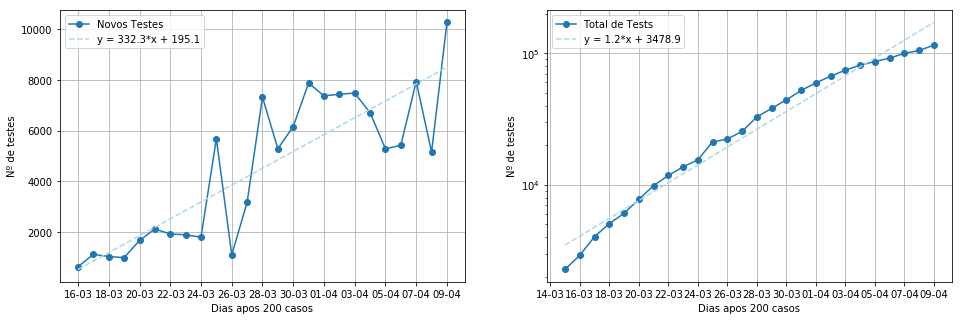

In [31]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['NewTests'], '-o', label='Novos Testes')
# fit
x = pt_casos.ndia[pt_casos['NewTests'].notnull()]
params = np.polyfit(x, pt_casos['NewTests'].dropna(), 1)
date = pt_casos.Date[pt_casos['NewTests'].notnull()]
plt.plot(date, (params[0])*x+params[1], '--', color='lightblue', label='y = %.1f*x + %.1f' % (params[0], params[1]))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Dias apos ' + str(n_casos_analise) +' casos')
plt.ylabel('Nº de testes')
plt.legend()

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TotalTests'], '-o', label='Total de Tests')
plt.yscale('log')
# fit
x = pt_casos.ndia[pt_casos['TotalTests'].notnull()]
params = np.polyfit(x, np.log(pt_casos['TotalTests'].dropna()), 1)
date = pt_casos.Date[pt_casos['TotalTests'].notnull()]

y = np.exp(params[0]*x) * np.exp(params[1])
plt.plot(date, y, '--', color='lightblue', label='y = %.1f*x + %.1f' % (np.exp(params[0]), np.exp(params[1])))

plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Nº de testes')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.legend()
plt.show()

Taxa de Transmissibilidade ($R_0$)

## COMPARAÇÃO COM OUTROS PAISES <a name="comparacao_outros_paises"></a>

In [32]:
#table = pd.read_csv("covid19-global-forecasting-week-1\\train.csv")

In [33]:

#es_casos = table[(table['Country/Region']=='Spain') & (table['ConfirmedCases'] >= n_casos_analise)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
#es_casos['ndia'] = list(range(0, len(es_casos['ConfirmedCases'])))

#it_casos = table[(table['Country/Region']=='Italy') & (table['ConfirmedCases'] >= n_casos_analise)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
#it_casos['ndia'] = list(range(0, len(it_casos['ConfirmedCases'])))